<a href="https://colab.research.google.com/github/gitgeek28/Asset-Price-Prediction/blob/main/Asset_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Asset Price Prediction using Machine Learning

This notebook demonstrates how to use various ML models to predict stock prices, including LSTM, ARIMA, and XGBoost.

## 🔁 ARIMA Model (Statistical Time Series)
AutoRegressive Integrated Moving Average model is used as a traditional forecasting approach.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df = df[['Date', 'Close']]
df = df.rename(columns={'Close': 'close'})
df.set_index('Date', inplace=True)
df.head()

,close
Date,
2012-01-03,663.59
2012-01-04,666.45
2012-01-05,657.21
2012-01-06,648.24
2012-01-09,620.76


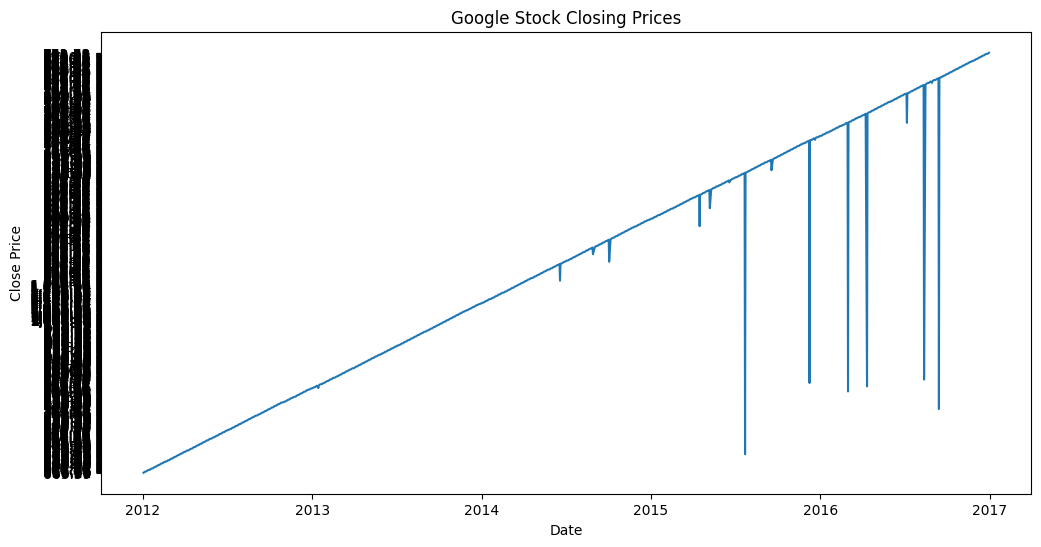

In [6]:
plt.figure(figsize=(12,6))
plt.plot(df['close'])
plt.title('Google Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [7]:
df['close'] = df['close'].replace({',': ''}, regex=True).astype(float)

df['SMA_14'] = df['close'].rolling(window=14).mean()

df['EMA_14'] = df['close'].ewm(span=14, adjust=False).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

# RSI
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [8]:
df = df.dropna()

In [9]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [10]:
arima_train = train['close']
arima_test = test['close']

model = ARIMA(arima_train, order=(5,1,0))
model_fit = model.fit()
arima_pred = model_fit.forecast(steps=len(arima_test))

print('ARIMA RMSE:', np.sqrt(mean_squared_error(arima_test, arima_pred)))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA RMSE: 34.594894649599865


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [11]:
for lag in range(1, 6):
    df[f'lag_{lag}'] = df['close'].shift(lag)

df = df.dropna()

features = ['SMA_14', 'EMA_14', 'MACD', 'RSI'] + [f'lag_{i}' for i in range(1,6)]
X = df[features]
y = df['close']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## 🌲 XGBoost Model (Machine Learning)
Extreme Gradient Boosting model using lag features for stock price prediction.

In [12]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, xgb_pred)))

XGBoost RMSE: 9.817055317193104


In [13]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['close']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_lstm, y_lstm = create_sequences(scaled_close, seq_length)

X_lstm_train = X_lstm[:train_size-seq_length]
y_lstm_train = y_lstm[:train_size-seq_length]
X_lstm_test = X_lstm[train_size-seq_length:]
y_lstm_test = y_lstm[train_size-seq_length:]

X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

## 📊 LSTM Model (Deep Learning)
A Long Short-Term Memory (LSTM) network is used to capture time-dependent patterns in stock price data.

In [14]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_lstm_train, y_lstm_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0483 - val_loss: 0.0024
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0121 - val_loss: 9.9924e-04
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0079 - val_loss: 0.0013
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0090 - val_loss: 0.0015
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0063 - val_loss: 0.0010
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0046 - val_loss: 6.1747e-04
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0054 - val_loss: 6.5047e-04
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0078 - val_loss: 6.1773e-04
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss

In [15]:
lstm_pred = model.predict(X_lstm_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_lstm_test_inv = scaler.inverse_transform(y_lstm_test.reshape(-1,1))

print('LSTM RMSE:', np.sqrt(mean_squared_error(y_lstm_test_inv, lstm_pred)))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
LSTM RMSE: 14.624463484204279


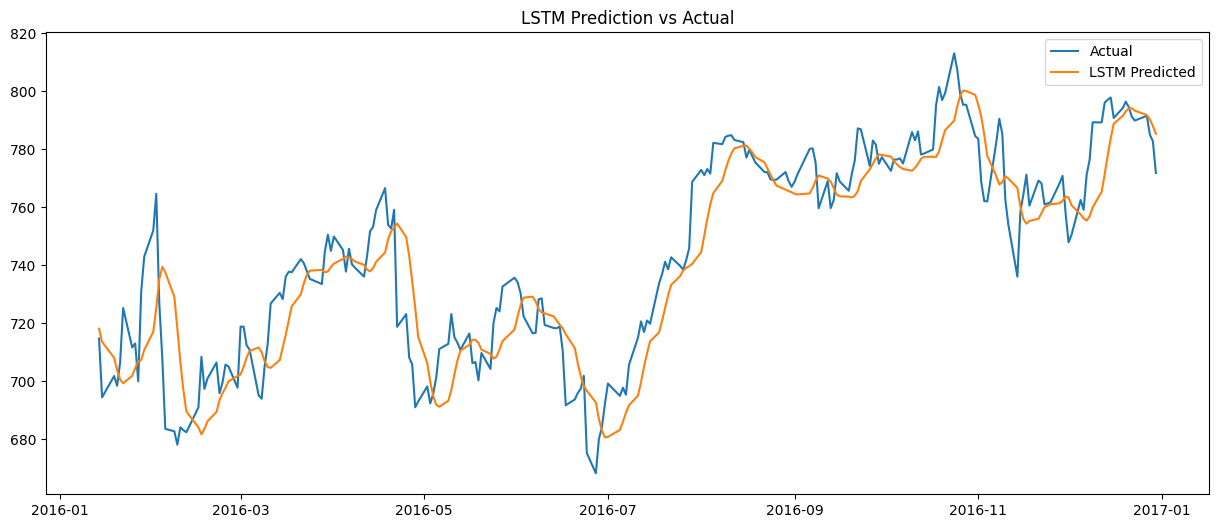

In [16]:
plt.figure(figsize=(15,6))
plt.plot(df.index[-len(y_lstm_test):], y_lstm_test_inv, label='Actual')
plt.plot(df.index[-len(y_lstm_test):], lstm_pred, label='LSTM Predicted')
plt.legend()
plt.title('LSTM Prediction vs Actual')
plt.show()

## Final Results
AutoRegressive Integrated Moving Average model is used as a traditional forecasting approach.

In [17]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'XGBoost', 'LSTM'],
    'RMSE': [
        np.sqrt(mean_squared_error(arima_test, arima_pred)),
        np.sqrt(mean_squared_error(y_test, xgb_pred)),
        np.sqrt(mean_squared_error(y_lstm_test_inv, lstm_pred))
    ]
})
print(results)

     Model       RMSE
0    ARIMA  34.594895
1  XGBoost   9.817055
2     LSTM  14.624463


## Prediction File

In [20]:
# Get the date index for the last 244 days of the test set
prediction_dates = test.index[-len(y_lstm_test_inv):]

# Create a DataFrame with actual values and predictions, aligned by date
predictions_df = pd.DataFrame({
    'Date': prediction_dates,
    'Actual_Close': test.loc[prediction_dates, 'close'],
    'ARIMA_Prediction': arima_pred[-len(prediction_dates):].values.flatten(),
    'XGBoost_Prediction': xgb_pred[-len(prediction_dates):].flatten(),
    'LSTM_Prediction': y_lstm_test_inv.flatten()
})

display(predictions_df.head())

,Date,Actual_Close,ARIMA_Prediction,XGBoost_Prediction,LSTM_Prediction
Date,,,,,
2016-01-14,2016-01-14,714.72,743.190850,716.687561,714.72
2016-01-15,2016-01-15,694.45,743.191305,720.807190,694.45
2016-01-19,2016-01-19,701.79,743.191061,703.181458,701.79
2016-01-20,2016-01-20,698.45,743.191055,714.713440,698.45
2016-01-21,2016-01-21,706.59,743.191085,701.538574,706.59


In [21]:
predictions_df.to_csv('predictions.csv', index=False)